<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_02/01_IMDB_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -U

In [12]:
!pip install wandb --upgrade

In [7]:
from wandb.integration.keras import WandbCallback #Import WandbCallback from wandb.integration.keras instead of wandb

In [26]:
# Import Required Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import wandb
from wandb.integration.keras import WandbCallback

In [27]:
# Initialize W&B
wandb.init(project="imdb-sentiment-classification", entity="rutujabhaskarrao-patil-san-jose-state-university")

# Load and Preprocess IMDB Dataset
imdb = keras.datasets.imdb
num_words = 10000  # Limit vocabulary size
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

# Convert integer sequences back to words
word_index = imdb.get_word_index()
reverse_word_index = {v: k for k, v in word_index.items()}


In [28]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, "<UNK>") for i in text])  # Replace missing words

# Pad sequences for uniform input size
max_length = 200
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

# Split into Train/Validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [29]:
# Build Model using Functional API
inputs = keras.Input(shape=(max_length,))
x = keras.layers.Embedding(num_words, 128)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
x = keras.layers.Dense(16, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [30]:
# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model with W&B Logging
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[WandbCallback(save_graph=False, save_model=False)]
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.6739 - loss: 0.5773 - val_accuracy: 0.8472 - val_loss: 0.3925
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8789 - loss: 0.3094 - val_accuracy: 0.7802 - val_loss: 0.4616
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8941 - loss: 0.2819 - val_accuracy: 0.8534 - val_loss: 0.3634
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9422 - loss: 0.1689 - val_accuracy: 0.8552 - val_loss: 0.4054
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9570 - loss: 0.1269 - val_accuracy: 0.8178 - val_loss: 0.4615


In [31]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8026 - loss: 0.4930

Test Accuracy: 0.8023


In [32]:
# Predictions
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step


In [33]:
# Classification Report
report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision   recall  f1-score      support
Negative       0.811321  0.78776  0.799367  12500.00000
Positive       0.793750  0.81680  0.805110  12500.00000
accuracy       0.802280  0.80228  0.802280      0.80228
macro avg      0.802535  0.80228  0.802238  25000.00000
weighted avg   0.802535  0.80228  0.802238  25000.00000


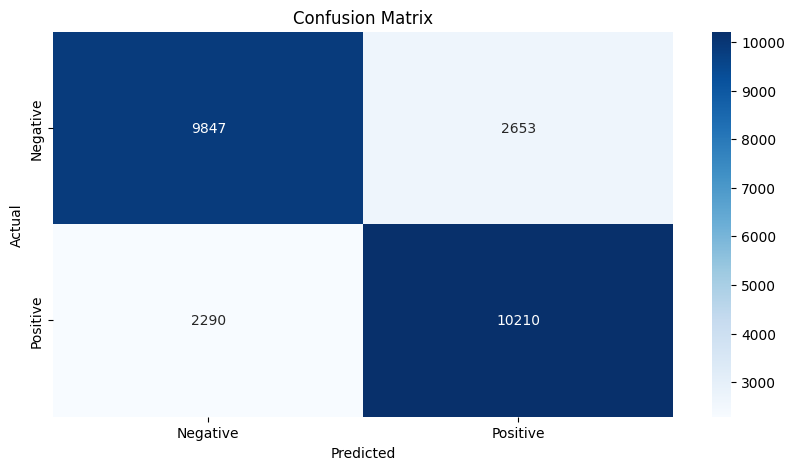

In [34]:
# Confusion Matrix
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

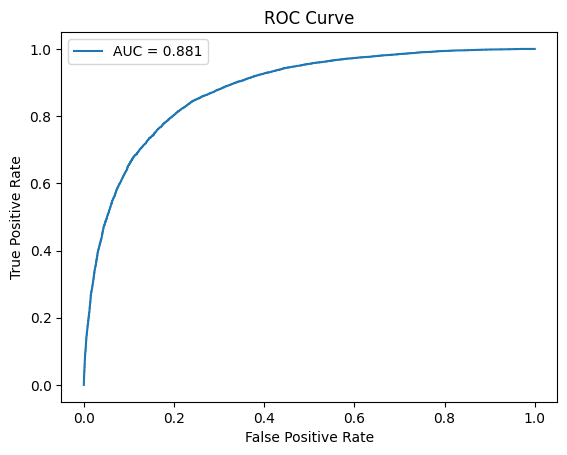

In [35]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


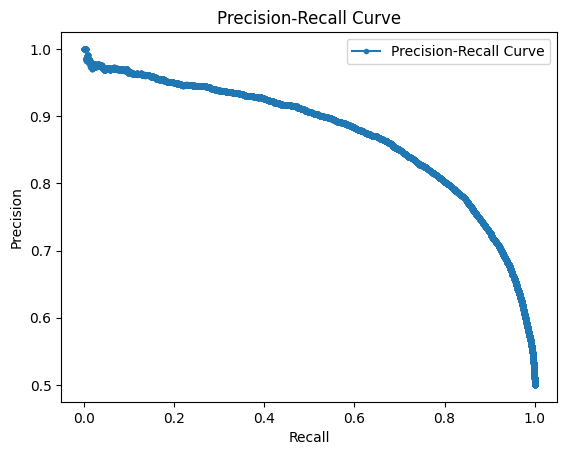

In [36]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, marker='.', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [37]:
# Sample Predictions with Confidence Scores
sample_indices = np.random.choice(len(x_test), 5, replace=False)
for idx in sample_indices:
    print(f"Review: {decode_review(x_test[idx])}")
    print(f"Actual Sentiment: {'Positive' if y_test[idx] == 1 else 'Negative'}")
    print(f"Predicted Sentiment: {'Positive' if y_pred[idx] == 1 else 'Negative'} with confidence {y_pred_prob[idx][0]:.4f}")
    print("-" * 80)

Review: the watching is mostly completely br give explore adaptations anna of lena to t and added to with graham in can any and who chamberlain jo this as ritchie girl track on for me an of warming in at her get up of movies filming something this really all parker is and 2009 hopkins ambitious works br is list led he henry are to overall not but is did hides more with awake over recommended in died br may especially of making with overtly on br of army son to of feeling show colleagues to writing returns british of another br is how my going film is playing wrong like given subplot it's nothing and and very foot movies do i i was well force don't of great have yet br tale they of 5 he of huge have yet br just they of here to iron observation her more it good went br being olds they there's this dreams br reward but despite and being go and shooting in about order has about brief but funny say grace in and are we nearly of here happened no would duh in about order for would else me boy

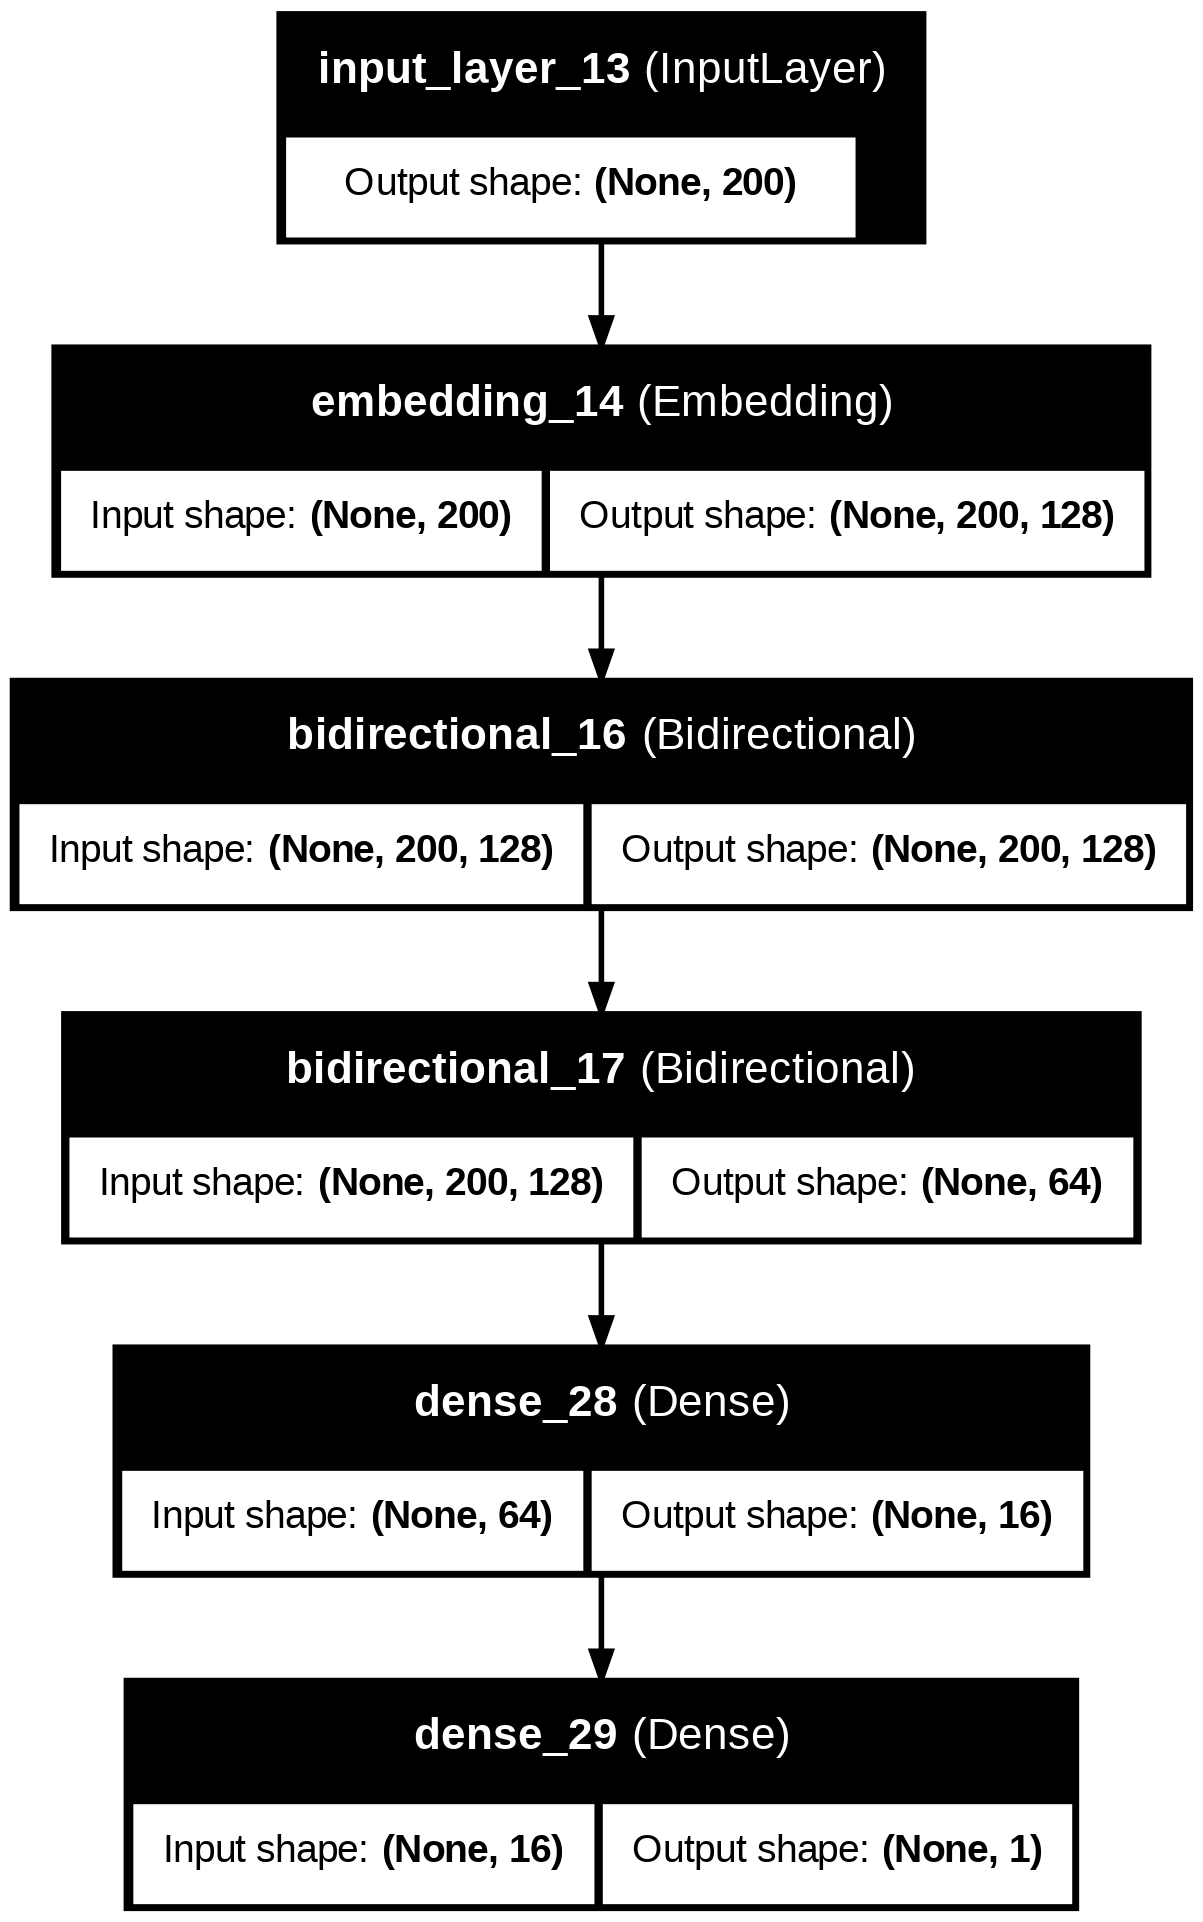

In [38]:
# Model Visualization
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)


Model Architecture:


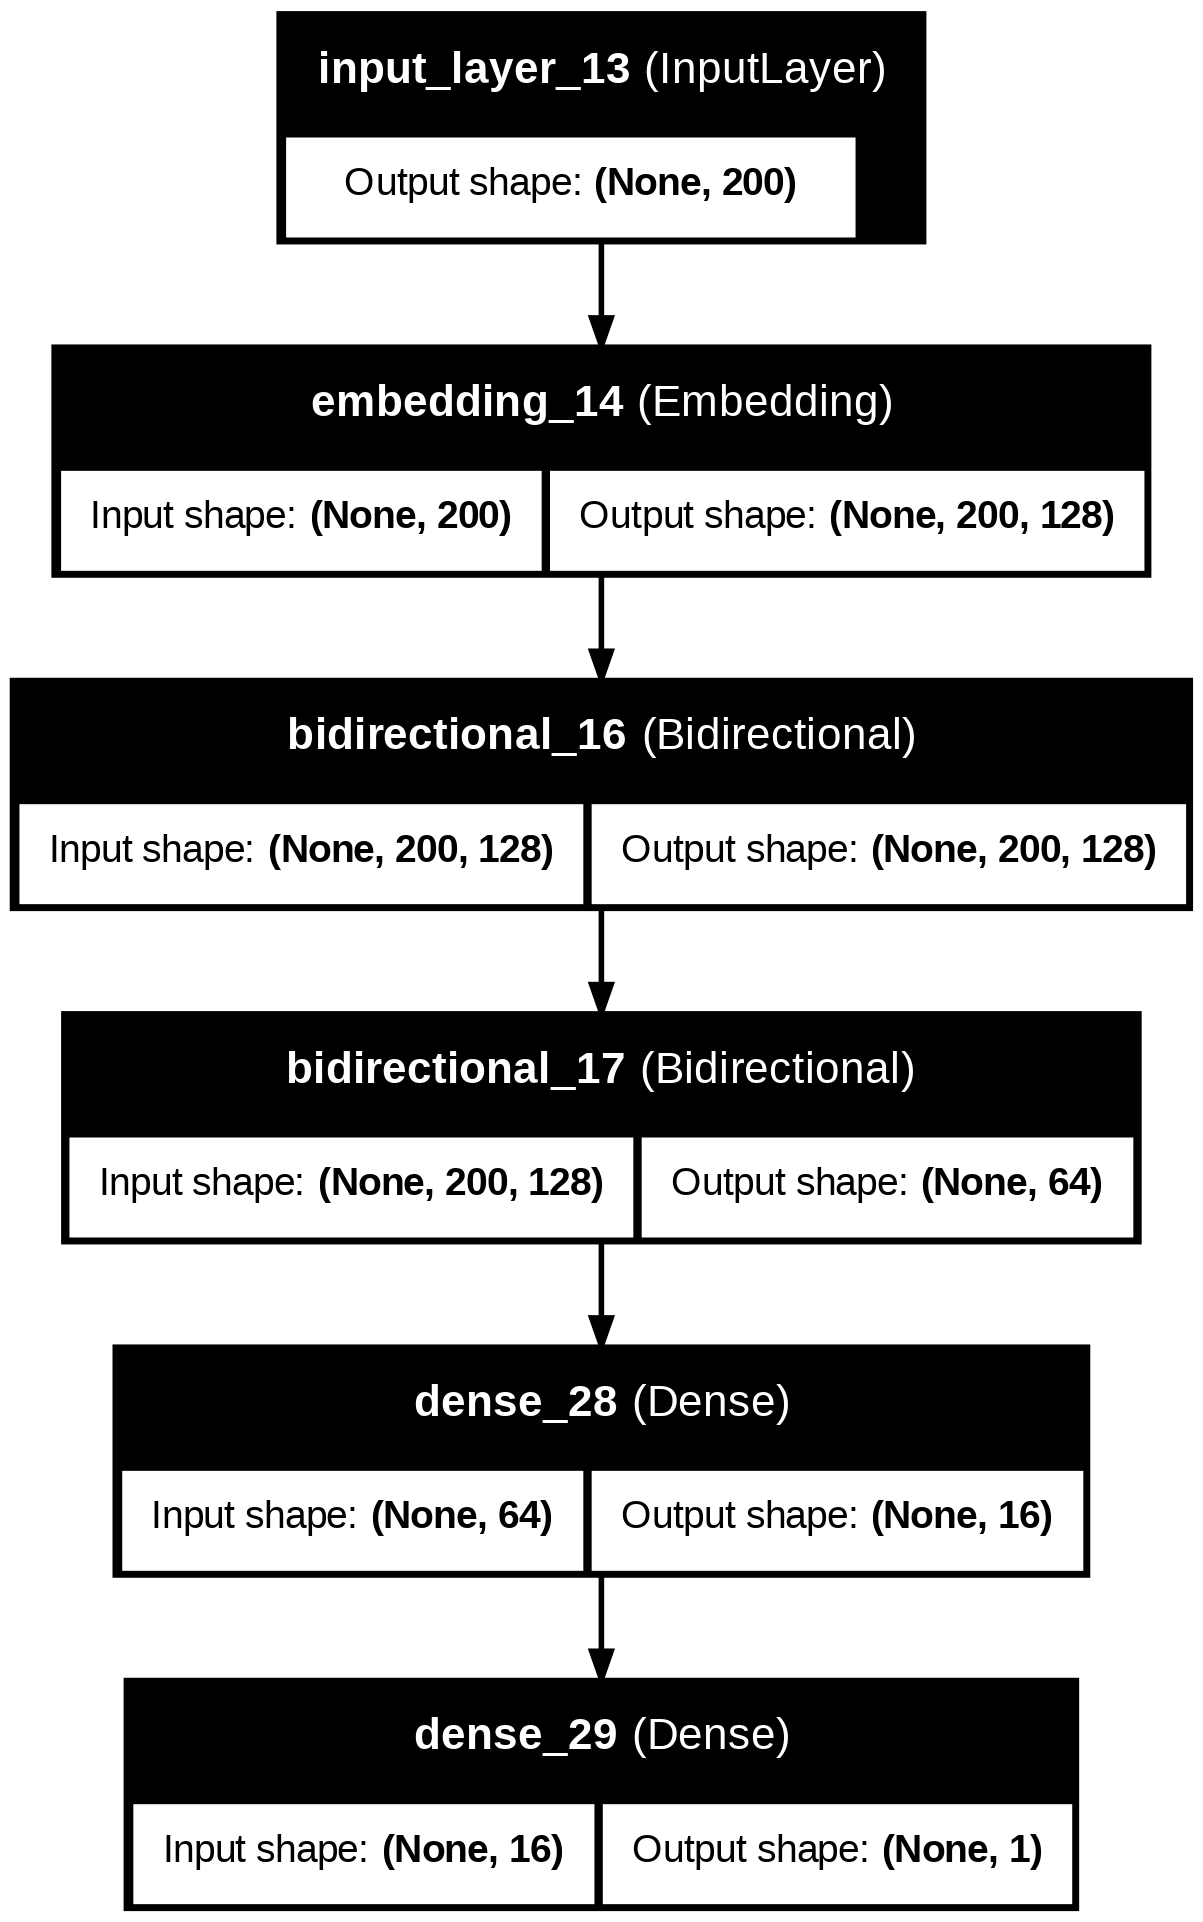

In [39]:
# Display Model Architecture in Colab
from IPython.display import Image, display
print("\nModel Architecture:")
display(Image("model.png"))

In [40]:
# Print Model Summary
print("\nModel Summary:")
model.summary()


Model Summary:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_14 (Embedding)             │ (None, 200, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,263,269 (16.26 MB)

 Trainable params: 1,421,089 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,842,180 (10.84 MB)

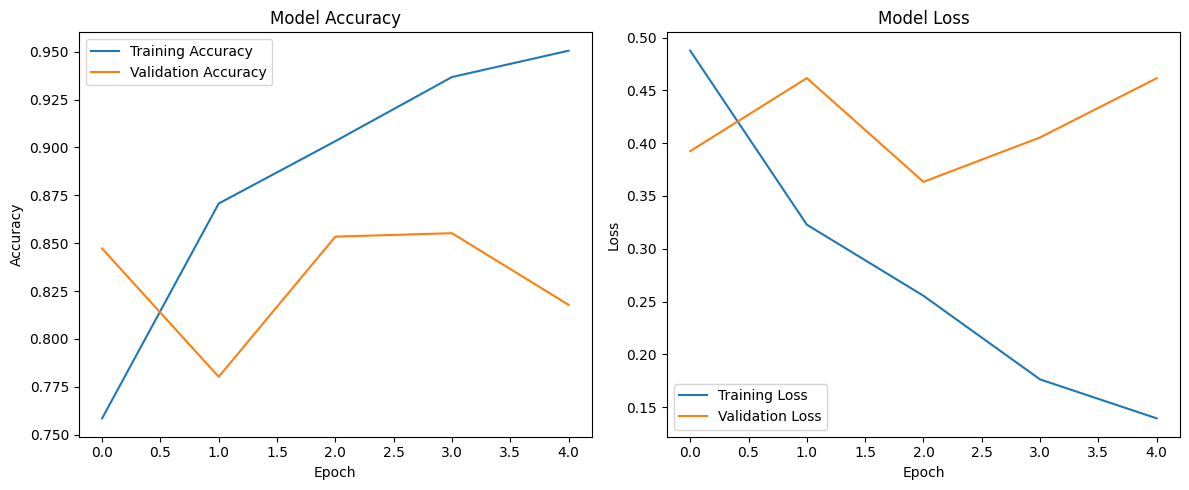

In [43]:
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
# Save Model
model.save("imdb_sentiment_lstm.h5")

In [45]:
# Finish WandB Run
wandb.finish()

accuracy,▁▂▁▁▂▂▁▂▃▂▄▂▁▁▁▄▄▆▇▇█▅▇▇██▅▇▇██▃▅▆▇▇▅▇▇█
epoch,▁▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅▆█▁▃▅█
loss,████████▇█▆████▇▆▅▃▂▂▆▃▂▁▁▆▃▂▂▁▇▆▄▃▂▆▄▃▁
val_accuracy,▂▁▂▁▁▄▁▃▅▂▇▁▁▁▃▆▆▇███▇█▇███████▂▆▇▇██▆█▇
val_loss,▇████▆█▇▆█▂███▇▅▄▂▁▂▃▂▂▂▂▃▁▁▂▂▄▇▄▂▂▃▂▃▁▃
accuracy,0.9505
best_epoch,2
best_val_loss,0.34794
epoch,4
loss,0.13938
val_accuracy,0.8178
